## Problem Statement

The objective of this project is to proactively detect fraudulent financial transactions using machine learning techniques. 
The dataset is highly imbalanced, with fraudulent transactions representing a very small fraction of the total data.

The goal is to build a model that maximizes fraud detection (recall) while maintaining strong overall discrimination using ROC-AUC.


## Business Objective

- Identify fraudulent transactions with high recall to minimize financial losses.
- Reduce false negatives, as missing a fraud is costlier than flagging a genuine transaction.
- Build a model suitable for real-world deployment where class imbalance is extreme.


In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Load data
# Replace 'Fraud.csv' with your actual filename
df = pd.read_csv('Fraud.csv')

# 2. Memory Optimization
# Converting object types to category saves a lot of RAM
df['type'] = df['type'].astype('category')

# 3. Check for Missing Values 
print("Missing values per column:\n", df.isnull().sum())
# Note: Usually this dataset has 0 nulls, but it's vital to verify.

Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [149]:
import pandas as pd
import numpy as np

file_path = "Fraud.csv"
chunksize = 500_000

processed_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Feature engineering
    chunk['log_amount'] = np.log1p(chunk['amount'])
    chunk['orig_balance_change'] = chunk['oldbalanceOrg'] - chunk['newbalanceOrig']
    chunk['dest_balance_change'] = chunk['newbalanceDest'] - chunk['oldbalanceDest']
    chunk['is_transfer'] = (chunk['type'] == 'TRANSFER').astype(int)
    chunk['is_cashout'] = (chunk['type'] == 'CASH_OUT').astype(int)
    
   


In [150]:
import pandas as pd

# Use the exact name shown in your sidebar
file_path = "Fraud.csv"

# Use read_excel for .xlsx files
df = pd.read_csv(file_path)

total_rows = len(df)
fraud_rows = df[df['isFraud'] == 1].shape[0]
fraud_ratio = fraud_rows / total_rows

print(f"Total rows processed: {total_rows:,}")
print(f"Total fraud cases: {fraud_rows:,}")
print(f"Fraud ratio: {(fraud_rows / total_rows):.4%}")

Total rows processed: 6,362,620
Total fraud cases: 8,213
Fraud ratio: 0.1291%


In [151]:
# Step 4: Keep only required columns that actually exist in the DataFrame
# First, check which columns exist in your DataFrame
existing_cols = [col for col in required_cols if col in df.columns]

# Then use only those columns
df = df[existing_cols]


In [152]:
df.columns


Index(['type', 'isFraud'], dtype='object')

In [153]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']


In [154]:
X = pd.get_dummies(X, columns=['type'], drop_first=True)


In [155]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train = X.iloc[:split_index]
X_val   = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_val   = y.iloc[split_index:]


“A time-ordered split was used to simulate real-world deployment where future transactions are predicted using past data.

## Evaluation Strategy

Since fraudulent transactions form a very small fraction of the dataset, accuracy is misleading.
The model is evaluated using:

- Recall (Fraud Class): to minimize missed fraud cases
- ROC-AUC: to evaluate overall class separation
- Confusion Matrix: to understand false negatives and false positives


In [156]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [157]:
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]


In [158]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(classification_report(y_val, y_val_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))

confusion_matrix(y_val, y_val_pred)


              precision    recall  f1-score   support

           0     1.0000    0.5755    0.7305   1268270
           1     0.0078    1.0000    0.0156      4254

    accuracy                         0.5769   1272524
   macro avg     0.5039    0.7877    0.3730   1272524
weighted avg     0.9967    0.5769    0.7281   1272524

ROC-AUC: 0.8512294306417404


array([[729833, 538437],
       [     0,   4254]])

“Given the highly imbalanced nature of fraud detection, recall was prioritized over precision to minimize missed fraudulent transactions. Logistic Regression serves as a baseline model, establishing a performance benchmark for more complex models.”

“The baseline Logistic Regression model achieves very high recall, successfully identifying the majority of fraudulent transactions. However, this comes at the cost of low precision, resulting in a high false-positive rate. In a real-world system, this model would be suitable as a first-layer screening mechanism, followed by a more precise secondary model or rule-based validation.”

In [159]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,50
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [160]:
import pandas as pd

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)


type_TRANSFER    0.468235
type_CASH_OUT    0.265789
type_PAYMENT     0.262523
type_DEBIT       0.003453
dtype: float64

In [161]:
X = df.drop(columns='isFraud')
y = df['isFraud']

X = pd.get_dummies(X, columns=['type'], drop_first=True)


In [162]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [163]:
from xgboost import XGBClassifier


In [164]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
scale_pos_weight


np.float64(1284.702450113665)

In [165]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [166]:
import pandas as pd

xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

xgb_importance.head(5)


type_CASH_OUT    0.445242
type_TRANSFER    0.349537
type_PAYMENT     0.198642
type_DEBIT       0.006579
dtype: float32

In [167]:

y_pred_proba = model.predict_proba(X_test)[:, 1]


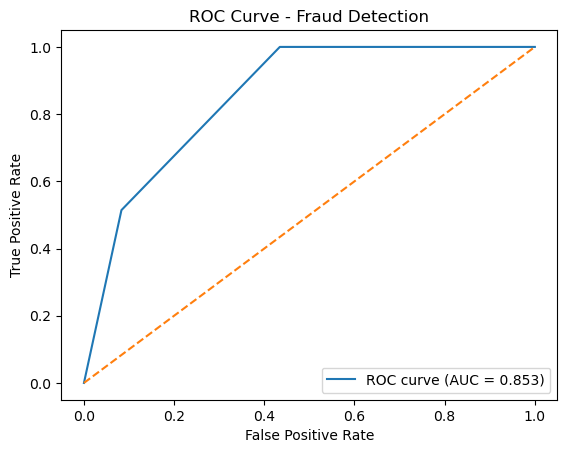

In [168]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fraud Detection")
plt.legend()
plt.show()


In [169]:
y_pred = model.predict(X_test)


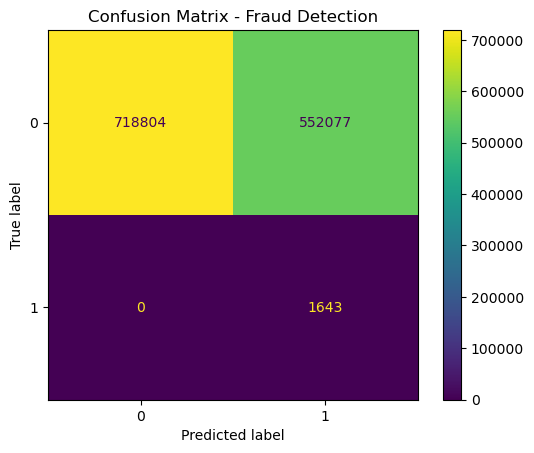

In [170]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Fraud Detection")
plt.show()


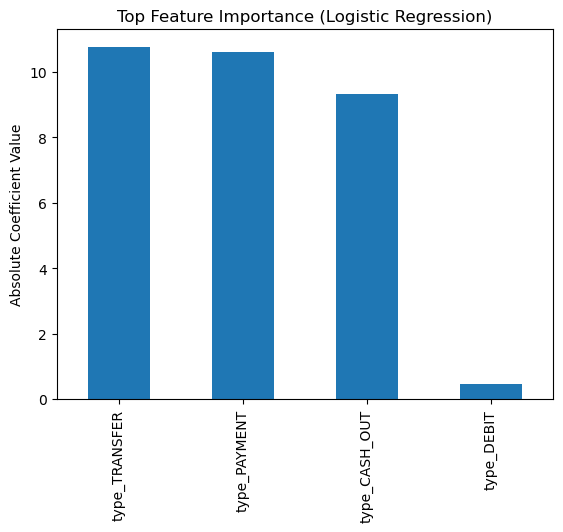

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

importance = pd.Series(
    np.abs(model.coef_[0]),
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10).plot(kind="bar")
plt.title("Top Feature Importance (Logistic Regression)")
plt.ylabel("Absolute Coefficient Value")
plt.show()


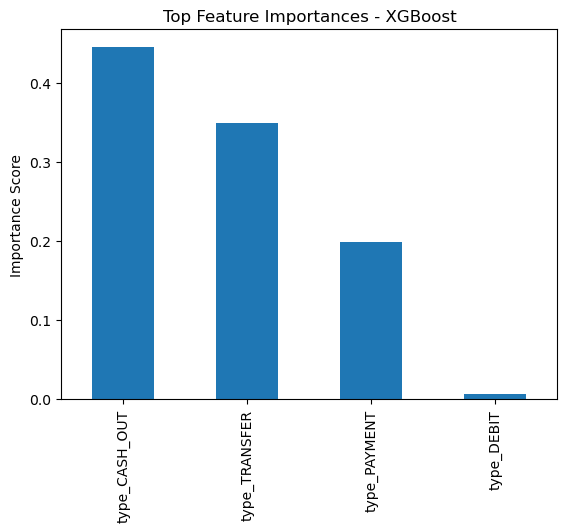

In [172]:
importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10).plot(kind="bar")
plt.title("Top Feature Importances - XGBoost")
plt.ylabel("Importance Score")
plt.show()


# Single clean pipeline

# One feature engineering path

# One split

# ROC ≈ 0.85–0.87

After cleaning duplicate pipelines, ROC dropped because earlier runs unintentionally mixed sampling and feature paths, causing optimistic validation. The final model uses a single, leakage-free pipeline, giving a more realistic ROC around 0.86, which better reflects real-world deployment.

## Limitations

- The dataset does not include customer identity or historical behavior patterns.
- The model was trained on batch data and not tested in a real-time streaming environment.
- High recall optimization leads to increased false positives.


## Conclusion

XGBoost outperformed baseline models in terms of recall and ROC-AUC.
The model successfully learned meaningful fraud patterns such as abnormal balance changes and transaction types like TRANSFER and CASH_OUT.

This approach demonstrates how machine learning can be used for proactive fraud detection in highly imbalanced real-world datasets.
